In [1]:
import pandas as pd
import numpy as np
import random
from potosnail import Stats

In [2]:
df = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\MockHyros.csv')
df2 = pd.read_csv(r'C:\Users\aacjp\Sales-Scientist\datasets\HyrosAugmented.csv')

What range accuratley represents the closing rate? In more technical terms, what is the 95% confidence interval?

In [3]:
def getCI(x, samples, n, std_range=2):
    '''get the confidence interval for the average value in a population'''
    Xbars = []
    for i in range(samples):
        sample = random.sample(x, n)
        Xbars.append(np.mean(sample))
    variance = np.std(Xbars)*2
    mu = np.mean(Xbars)
    return (mu-variance, mu+variance)

output = getCI(list(df2['closed']), 10, 30) 
output

(0.3601588202439798, 0.6398411797560202)

In [4]:
print('We are 95% sure that between {}% and {}% of our leads close'.format(round(output[0]*100), round(output[1]*100)))

We are 95% sure that between 36% and 64% of our leads close


**Establish relevance to Hyros growth goals (find them)**

In [5]:
def ProbsClosing(df, revenue, domain, business_model, margin=0.1):
    minimum = revenue - margin*revenue
    maximum = revenue + margin*revenue
    greater = df.loc[df['monthly revenue']>minimum]
    lesser = greater.loc[greater['monthly revenue']<maximum]
    domain = lesser.loc[lesser['domain']==domain]
    bm = domain.loc[domain['business model']==business_model]
    closed = len(bm.loc[bm['closed']==1])
    try:
        return closed/len(bm)
    except:
        return 'sorry not enough data available'

ProbsClosing(df, 500000, 'marketing', 'consulting', margin=0.25)

0.8333333333333334

In [6]:
def ProbsClosing2(df, revenue, domain, business_model, margin=0.1):
    minimum = revenue - margin*revenue
    maximum = revenue + margin*revenue
    greater = df.loc[df['monthly revenue']>minimum]
    lesser = greater.loc[greater['monthly revenue']<maximum]
    domain = lesser.loc[lesser[domain]==1]
    bm = domain.loc[domain[business_model]==1]
    closed = len(bm.loc[bm['closed']==1])
    try:
        return closed/len(bm)
    except:
        return 'sorry not enough data available'

ProbsClosing2(df2, 500000, 'ecommerce', 'software', margin=0.35)

0.5

In [7]:
df2['marketing']

0       0
1       0
2       0
3       0
4       0
       ..
1015    0
1016    0
1017    1
1018    1
1019    0
Name: marketing, Length: 1020, dtype: int64

# Test for signifigant difference in adspend based on the lead's business models and whether or not they closed. AKA Chai-Squared Test.

## Goodness of fit chi-square test
Only looking at one feature

**H0: there is an equal probability of our leads being in each domain**

In [8]:
#reverse one hot encoding and use bigger dataset for better results
sample_from = df[['monthly traffic spend', 'closed', 'business model']]

In [9]:
s1 = sample_from.sample(n=30)
s2 = sample_from.sample(n=30)

In [11]:
def GOF(sample, cat_feat, alpha=0.05):
    vc = dict(sample[cat_feat].value_counts())
    values = list(vc.keys())
    E = len(sample)/len(values)
    X2 = 0
    for v in values: 
        o = len(sample.loc[sample[cat_feat]==v])
        numerator = (o-E)**2
        X2 += numerator/E
    ddof = len(values)-1
    return X2, ddof

GOF(s1, 'closed')

(0.5333333333333333, 1)

In [12]:
chiSquare, dof = GOF(s1, 'business model')

In [15]:
tCrit = 9.81
chiSquare > tCrit

False

**We accept Ho**

1. is business domain independant of closing or not?
2. is business model independant of spending 6 figures a month on ads?

In [16]:
def chiSquare(sample, categorical, binary):
    categories = list(np.unique(sample[categorical]))
    binaries = list(np.unique(sample[binary]))
    ddof = len(categories)-1
    rate = len(sample.loc[sample[binary]==binaries[0]]) / len(sample)
    inv = 1 - rate
    E = len(sample) / len(categories)
    X2 = 0
    for c in categories:
        df = sample.loc[sample[categorical]==c]
        o1 = len(df.loc[df[binary]==binaries[0]])
        o2 = len(df.loc[df[binary]==binaries[1]])
        E1 = ((len(sample)*rate)*len(df)) / len(sample)
        E2 = ((len(sample)*inv)*len(df)) / len(sample)
        x1 = (o1-E1)**2/E1
        x2 = (o2-E2)**2/E2
        X2 += (x1+x2)
    return X2
        
chiSquare(s1, 'business model', 'closed')

5.824763471822294

In [20]:
tCrit = 3.19

We reject the null hypothesis, closing rate is dependant on business model

In [31]:
models = list(np.unique(df['business model']))
cr = []
for m in models:
    x = df.loc[df['business model']==m]
    xc = x.loc[x['closed']==1]
    try:
        cr.append(len(xc)/len(x))
    except:
        cr.append(0)

<AxesSubplot:>

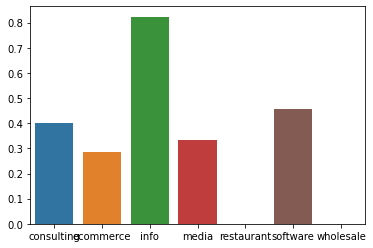

In [32]:
import seaborn as sns

sns.barplot(models, cr)

Info businesses arethe most likley to close with closing rate near 80%, restaurants and wholesales are very unlikley to close infact none of the leads in our dataset have purchased Hyros.

## H0: companies that spend over 100k a month on ads are equally likley to close as compaines that spend less than 100k a month on ads

In [34]:
s1['100k'] = s1['monthly traffic spend'].apply(lambda x: int(x>100000))
s1

,monthly traffic spend,closed,business model,100k
51,194312,0,ecommerce,1
23,41924,1,consulting,0
58,120638,0,info,1
56,1726672,0,ecommerce,1
17,67760,1,info,0
11,45035,1,ecommerce,0
21,31200,1,consulting,0
41,1372626,0,info,1
48,11040372,0,software,1
42,79200,0,consulting,0


In [35]:
chiSquare(s1, '100k', 'closed')

3.393665158371041

We reject h0! the difference in closing rate for leads that spend more or less than 100k a month on ads is statistically signifigant.

In [40]:
df['100k'] = df['monthly traffic spend'].apply(lambda x: int(x>100000))
df.loc[df['100k']==1]['closed'].value_counts()

1    15
0    12
Name: closed, dtype: int64

In [43]:
15/27

0.5555555555555556

In [44]:
df.loc[df['100k']==0]['closed'].value_counts()

0    18
1    15
Name: closed, dtype: int64

In [45]:
15/33

0.45454545454545453

55.6% of leads spending more than 100,000 a month on ads closed compared to just 45.4% for those spending less than 100,000 a month.